# Demographics for Transit Oriented Communities entitlements

Let's take a close look at entitlement applications for Transit Oriented Communities (TOC).

In [1]:
import geopandas
import intake
import matplotlib.pyplot as plt
import numpy as np
import pandas
import sklearn.ensemble
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.pipeline
import sklearn.utils

import laplan

cat = intake.open_catalog("../catalogs/*.yml")

First, we load a bunch of relevant data.

In [2]:
# Census tracts
tracts = cat.census_tracts.read()

# Crosswalk from parcels to tracts
parcel_to_tract = cat.crosswalk_parcels_tracts.read()

# ACS data for income, race, commute, tenure
census = cat.census_analysis_table.read()

/home/ian/miniconda3/envs/civis/lib/python3.8/site-packages/pyarrow/compat.py:24: FutureWarning: pyarrow.compat has been deprecated and will be removed in a future release
  warnings.warn("pyarrow.compat has been deprecated and will be removed in a "


In [3]:
pcts = cat.pcts2.read()
pcts = laplan.pcts.subset_pcts(pcts, get_dummies=True, suffix_list=["TOC"], verbose=True)
pcts = laplan.pcts.drop_child_cases(pcts, keep_child_entitlements=True)

Parsing PCTS case numbers
2146 cases failed to parse.
Getting dummy indicators for case types
Prefixes with no associated cases:  {'APCE', 'APCSV', 'CHC', 'HPO', 'TT', 'VTT', 'ZA', 'APCC', 'APCNV', 'APCS', 'CPC', 'ENV', 'APCW', 'PS', 'APCH', 'AA'}


One of our primary variables for TOC entitlements is how many parcels are eligible.
Let's count the number of eligible parcels in each tier on a per-census-tract basis:

In [4]:
tier_parcels = (
    parcel_to_tract
    [parcel_to_tract.TOC_Tier > 0]
    .groupby(["GEOID", "TOC_Tier"])
    .size()
    .to_frame("n")
    .reset_index(level=1)
    .pivot(columns="TOC_Tier", values="n")
    .rename(columns=lambda x: f"Tier_{x}")
    .fillna(0.0)
    .astype(int)
)
tier_parcels

TOC_Tier,Tier_1,Tier_2,Tier_3,Tier_4
GEOID,,,,
06037104320,372,24,0,0
06037104401,166,0,0,0
06037104404,229,31,0,0
06037104610,408,29,0,0
06037104620,230,0,0,0
...,...,...,...,...
06037702502,5,0,0,0
06037703200,0,0,1,0
06037980009,5,0,0,0


In [5]:
pcts = pcts.merge(
    parcel_to_tract[["GEOID", "AIN", "TOC_Tier"]],
    how="left",
    on="AIN",
)

Get all of the tracts for which more than 50% of the parcels fall within one TOC tier.
Consider those tracts to be TOC tracts.

In [6]:
toc_eligible_tracts = parcel_to_tract.groupby("GEOID").agg({
    "TOC_Tier": lambda x: True if sum(x > 0)/len(x) >= 0.5 else False
})

Plot up the TOC-eligible tracts:

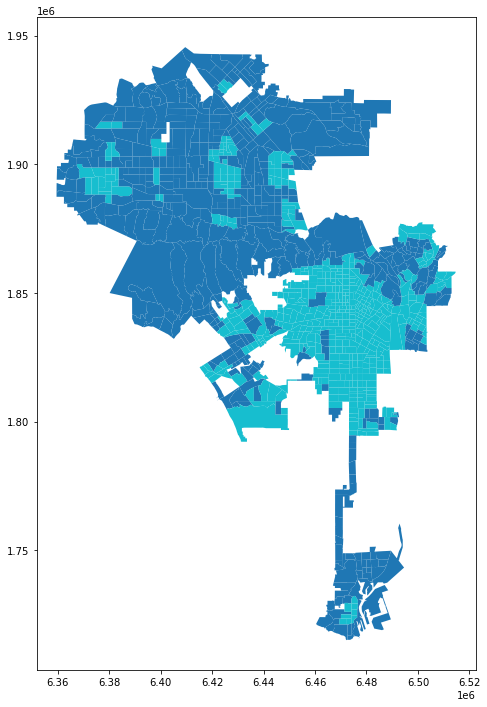

In [7]:
tracts.set_index("GEOID10").assign(toc=toc_eligible_tracts).plot(column="toc", figsize=(12,12))

Let's count the number of TOC entitlements per tract:

In [8]:
toc_count = pcts.dropna(subset=["GEOID"]).groupby(["CASE_ID"]).agg({
    "TOC": "first",
    "GEOID": lambda x: x.value_counts().index[0],
}).reset_index().groupby("GEOID").agg({
  "TOC": "count"  
})

In [9]:
joined = pandas.merge(
    census.set_index("GEOID"),
    tier_parcels,
    how="left",
    left_index=True,
    right_index=True,
).merge(
    toc_count,
    how="left",
    left_index=True,
    right_index=True,
).merge(
    toc_eligible_tracts.rename(columns={"TOC_Tier": "TOC_eligible"}),
    how="left",
    left_index=True,
    right_index=True
).fillna(0).dropna()

In [10]:
joined = geopandas.GeoDataFrame(joined, geometry=tracts.set_index("GEOID10").geometry)

## Demographics of TOC tracts

Let's investigate the demographic differences between TOC tracts and non-toc tracts.

In order to do so in a population-normalized way, we have to use population totals rather than percentages.

In [11]:
non_toc_pop = joined.groupby("TOC_eligible")["pop_total"].sum()[False]
toc_pop = joined.groupby("TOC_eligible")["pop_total"].sum()[True]
income_cols = [c for c in joined.columns if c.startswith("total_")]
demo_cols = [
    "non_car_workers",
    "zero_veh_workers",
    "pop_renter",
    "pop_whitenonhisp",
]
toc_pop_totals = joined.groupby("TOC_eligible")[[
    "pop_total",
    *demo_cols,
    *income_cols,
]].sum().astype("float")

In [12]:
toc_pop_totals.loc[False, demo_cols] = (
    toc_pop_totals.loc[False, demo_cols] / 
    toc_pop_totals.loc[False, "pop_total"]
)
toc_pop_totals.loc[True, demo_cols] = (
    toc_pop_totals.loc[True, demo_cols] / 
    toc_pop_totals.loc[True, "pop_total"]
)

In [13]:
toc_pop_totals.loc[False, "medhhincome"] = (
    laplan.census.income_percentiles(
        toc_pop_totals.loc[False],
        [50],
    )[0]
)
toc_pop_totals.loc[True, "medhhincome"] = (
    laplan.census.income_percentiles(
        toc_pop_totals.loc[True],
        [50],
    )[0]
)

In [14]:
toc_pop_totals[demo_cols + ["medhhincome"]].T.style.format("{:.2n}")

TOC_eligible,False,True
non_car_workers,0.039,0.095
zero_veh_workers,0.014,0.046
pop_renter,0.46,0.72
pop_whitenonhisp,0.38,0.22
medhhincome,74,48


## Modeling TOC entitlements

Let's use a Random Forest regressor as a baseline model for relating TOC permits to
demographic and zoning data. These models tend to do very well at fitting data and are simple to create.

In [15]:
variables = [
    "medhhincome",
    "pct_pop_renter",
    "pct_zero_veh_workers",
    "density",
    "pct_whitenonhisp",
    "Tier_1",
    "Tier_2",
    "Tier_3",
    "Tier_4",
]
target = "TOC"

In [16]:
to_fit = joined.dropna()[variables + [target, "geometry"]]

Let's visualize the spatial distribution of these variables to check that they make sense:

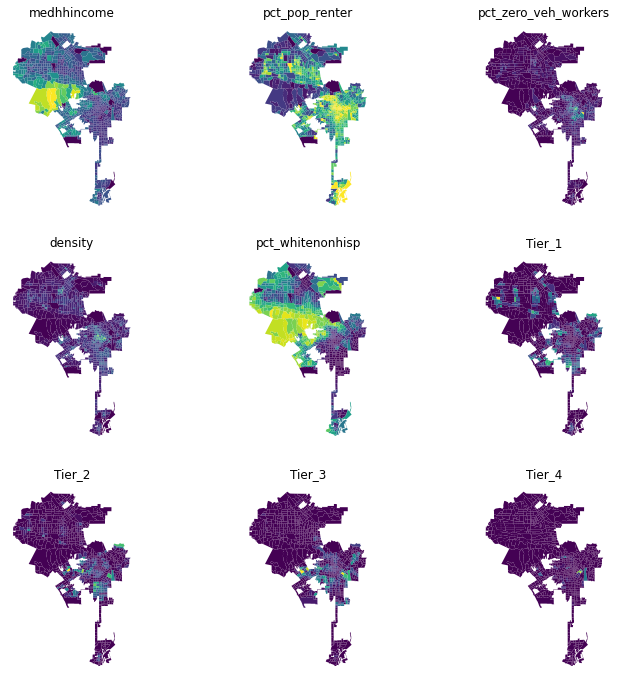

In [17]:
fig, axes = plt.subplots(3, 3, figsize=(12,12))
for i, var in enumerate(variables):
    ax = axes.ravel()[i]
    to_fit.plot(ax=ax, column=var)
    ax.axis("off")
    ax.set_title(var)

Filter to only fit counts in tracts that have *some* eligible parcels:

In [18]:
to_fit = to_fit[
    (to_fit.Tier_1 > 0) |
    (to_fit.Tier_2 > 0) |
    (to_fit.Tier_3 > 0) |
    (to_fit.Tier_4 > 0)
]

In [19]:
# Set a max depth to avoid over-fitting
random_forest_model = sklearn.pipeline.Pipeline([
    ("scaler", sklearn.preprocessing.StandardScaler(with_mean=True)),
    ("regressor", sklearn.ensemble.RandomForestRegressor(max_depth=10)),
])

In [20]:
def plot_model(predictions):
    vmin=0
    vmax=40
    cmap="plasma"
    fig, axes = plt.subplots(1,2, figsize=(16, 16))
    axes[0].axis("off")
    axes[0].set_title("Actual Number of TOC")
    (tracts
     .set_index("GEOID10")
     .assign(TOC=to_fit.TOC)
     .fillna({"TOC": 0})
     .plot(ax=axes[0],column="TOC", vmax=vmax, vmin=vmin, cmap=cmap)
    )
    axes[1].axis("off")
    axes[1].set_title("Predicted number of TOC")
    (tracts
     .set_index("GEOID10")
     .assign(predictions=pandas.Series(predictions, index=to_fit.index))
     .fillna({"predictions": 0})
     .plot(ax=axes[1],column="predictions", vmax=vmax, vmin=vmin, cmap=cmap)
    )
    plt.close(fig)
    return fig

Plot up the model to see how it does:

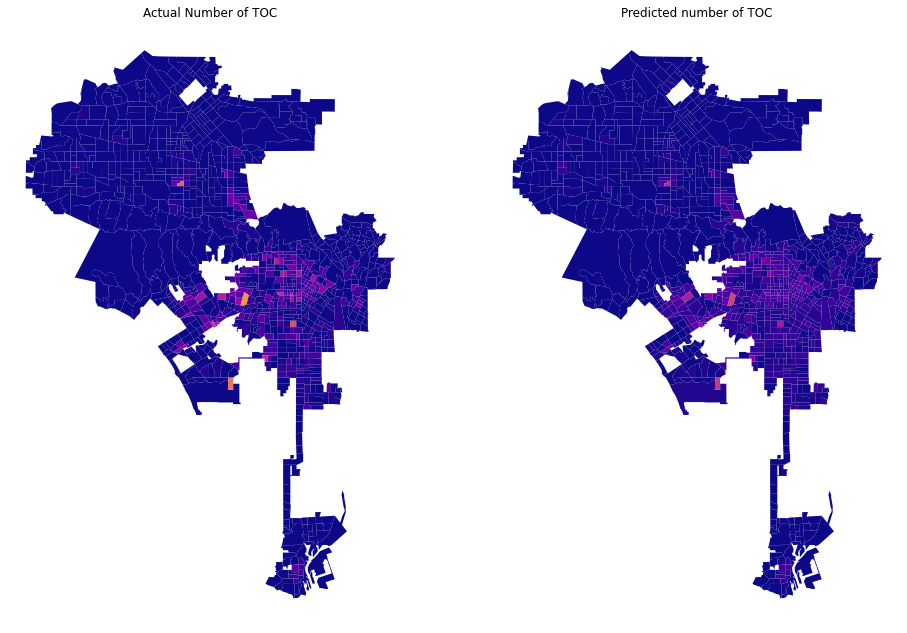

In [21]:
np.random.seed(1)

random_forest_model.fit(to_fit[variables], to_fit[target])
plot_model(random_forest_model.predict(to_fit[variables]))

In [22]:
print(f"Score: {random_forest_model.score(to_fit[variables], to_fit[target])}")
pandas.Series(
    random_forest_model["regressor"].feature_importances_,
    index=variables,
).sort_values(ascending=False)

Score: 0.8024338418102476


Tier_3                  0.213458
Tier_2                  0.194170
pct_pop_renter          0.171880
density                 0.095947
pct_zero_veh_workers    0.083160
pct_whitenonhisp        0.078807
medhhincome             0.078646
Tier_1                  0.057996
Tier_4                  0.025935
dtype: float64

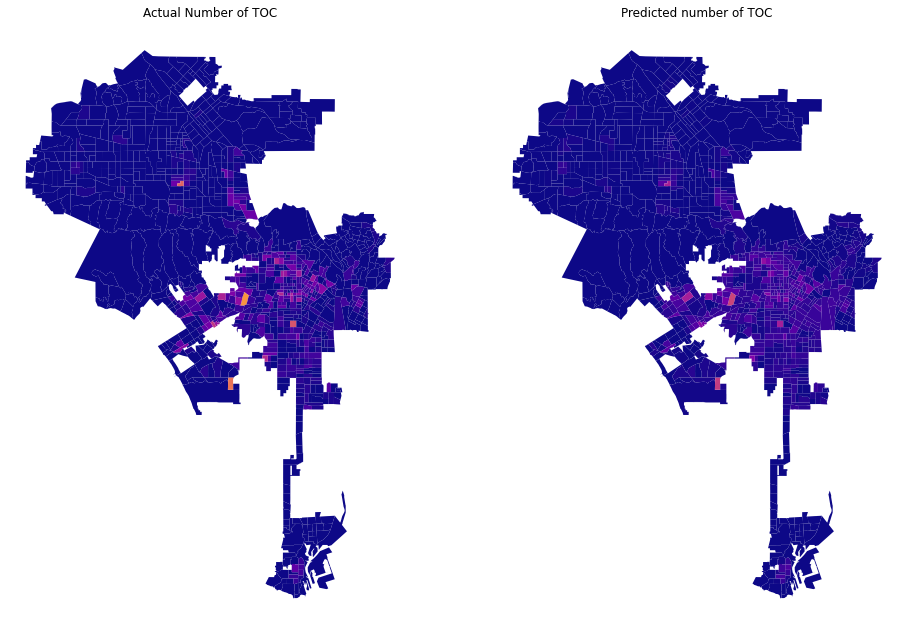

In [23]:
np.random.seed(1)
fewer_variables = [
    "Tier_3",
    "Tier_2",
    "pct_pop_renter",
]

random_forest_model.fit(to_fit[fewer_variables], to_fit[target])
plot_model(random_forest_model.predict(to_fit[fewer_variables]))

In [24]:
print(f"Score: {random_forest_model.score(to_fit[fewer_variables], to_fit[target])}")
pandas.Series(
    random_forest_model["regressor"].feature_importances_,
    index=fewer_variables
).sort_values(ascending=False)

Score: 0.7869177336283287


Tier_3            0.341381
pct_pop_renter    0.332532
Tier_2            0.326087
dtype: float64

Looks like it still does an acceptable job of predicing where the entitlements will be.
Unfortunately, random forest regression has a major drawback: it is difficult to interpret.
There is not a strong meaning we can attach to the decision tree splits,
and due to its ensemble nature, it is difficult to visualize.

We can instead try to fit the same data to a model with a strong backing process:
Poisson linear regression. In this model, the number of TOC entitlements are
modeled as a Poisson process, where the underlying rate is a log-linear function
of our features.


In [25]:
poisson_model = sklearn.pipeline.Pipeline([
    ("scaler", sklearn.preprocessing.StandardScaler(with_mean=True)),
    ("regressor", sklearn.linear_model.PoissonRegressor(fit_intercept=True, alpha=0.0, tol=1.e-6))
])

In [26]:
def sample_poisson_model(data, target, norm=1, seed=1): 
    def get_coefs(model):
        return model["regressor"].coef_
    rs = np.random.RandomState(seed)
    samples = np.array([
        get_coefs(
            poisson_model.fit(
                *sklearn.utils.resample(
                    data,
                    (target/norm).replace([np.nan, np.inf], 0.0),
                    random_state=rs,
                )
            )
        )
        for i in range(1000)
    ])
    return samples

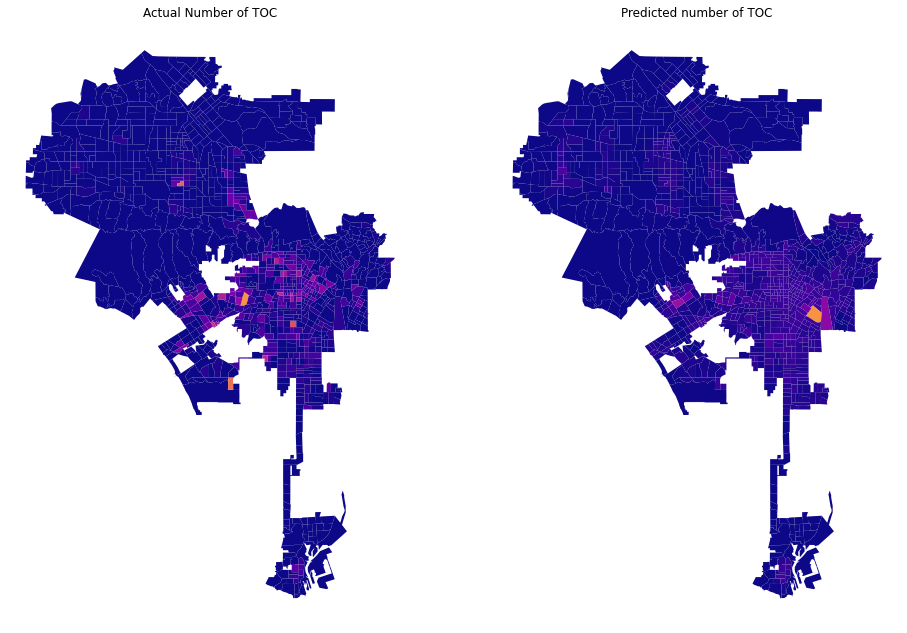

In [27]:
poisson_model.fit(to_fit[fewer_variables], to_fit[target])
plot_model(poisson_model.predict(to_fit[fewer_variables]))

In [28]:
print(f"Poisson Score: {poisson_model.score(to_fit[fewer_variables], to_fit[target])}")

Poisson Score: 0.22871853331229552


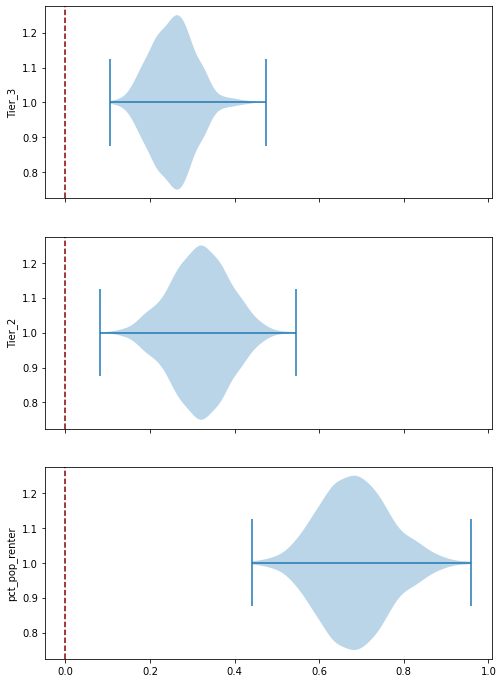

In [29]:
subset = fewer_variables
samples = sample_poisson_model(to_fit[subset], to_fit[target])

fig, axes = plt.subplots(
    len(subset),
    1,
    sharex=True,
    sharey=True,
    figsize=(8,12),

)

for i, var in enumerate(subset):
    ax = axes[i]
    ax.violinplot(samples[:,i], vert=False)
    ax.set_ylabel(var)
    ax.axvline(0, color="maroon", ls="--")

#### Interpreting the coefficients

In [30]:
scaler = poisson_model["scaler"]
regressor = poisson_model["regressor"]

In [31]:
beta = pandas.Series(regressor.coef_/scaler.scale_, index=fewer_variables)
alpha = regressor.intercept_ - np.dot(scaler.mean_ , beta)

In [32]:
import IPython.display

In [33]:
scale = 100
val = (np.exp(beta[0]*scale)-1.0)*100.
display(IPython.display.Markdown(
    f"For every {scale:,} Tier 3 parcels, "
    f"there is a {val:.0f}% increase in TOC entitlements"
))
scale = 100
val = (np.exp(beta[1]*scale)-1.0)*100.
display(IPython.display.Markdown(
    f"For every {scale:,} Tier 2 parcels, "
    f"there is a {val:.0f}% increase in TOC entitlements"
))
scale = 0.1
val = (np.exp(beta[2]*scale)-1)*100.
display(IPython.display.Markdown(
    f"For every {100*scale:g}% increase in population of renters, "
    f"there is a {val:.0f}% increase in TOC entitlements"
))

For every 100 Tier 3 parcels, there is a 13% increase in TOC entitlements

For every 100 Tier 2 parcels, there is a 27% increase in TOC entitlements

For every 10% increase in population of renters, there is a 33% increase in TOC entitlements